In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.image as mpimg
from IPython.display import clear_output

How to incorporate time like diff eqs

# 1d CA

mapping output to a language

combo (169,225) is dope +133?

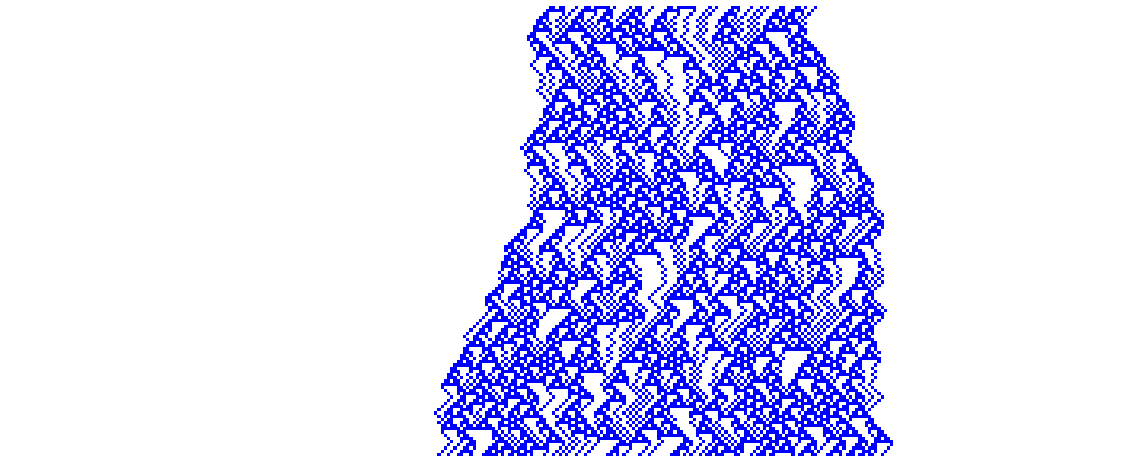

In [27]:
class CA:
    def __init__(self, rule = None):
        """If rule is list, then randomly changes between those rules"""
        #creating rule table
        if type(rule) == int:
            self.make_ruleset(rule)
        self.rule = rule
        #some combos
        self.pyramidal_rules = (18,22,26,28,30,50,54,58)
        self.cool_rules = (30,75,89,90,145) #not that cool
        self.alt = (60,110)
        self.alt2 = (24,34,226,252,238)
        self.robots = (3,6,9,11,25,107)
        
        
    def make_ruleset(self, _rule):
        _rule = bin(_rule)[2:]
        while len(_rule) is not 8:
            _rule = '0' + _rule
        
        neighbors = ('111','110','101','100','011','010','001','000')
        ruleset = dict.fromkeys(neighbors)
        for key, val in zip(neighbors, _rule):
            ruleset[key] = val

        self.ruleset = ruleset
        
    def update(self, curr_state):
        new_state = [0 for i in range(len(curr_state))]
        for i in range(1,len(curr_state) - 2): #avoiding edges
            l,c,r = curr_state[i - 1], curr_state[i], curr_state[i + 1]
            new_state[i] = int(self.ruleset[f'{l}{c}{r}'])
        return new_state

    def run(self, lifetime, width = None, t0 = None, plot = True, color='cool'):
        grid = [] #really a bunch of 1d state arrays
        if t0 is None:
            t0 = [0 for i in range(width)]
            t0[int(width/2)] = 1

        grid.append(t0)
        curr = t0
        for t in range(lifetime):
            if type(self.rule) != int:
                self.make_ruleset(np.random.choice(self.rule))
            curr = self.update(curr)
            grid.append(curr)
            
        grid = np.array(grid)[250:-10,200:-250 ]
        if plot:
            plt.imshow(grid,cmap=color)
            plt.axis('off')
            plt.show()

x = CA(rule = (169,225))
plt.figure(figsize=[20,20])
x.run(400,800, color = colors.ListedColormap(['blue', 'white']))

In [169]:
primes = input().split(' ')
primes = [int(i) for i in primes]

 29 31 37 41 43 47 53 59 61 67 71 73 79 83 89 97 101


# Ising model from loaded grayscale image

In [2]:
def metropolis_ising(T,runtime,N=None,grid=None):
    """grid: if you choose to initialize with previous image"""
    J = 1 #strength of interaction (Joules)
    k = 1 # Joules per kelvin
    if grid is not None:
        N = grid.shape[0]
    else:
        grid = 2*np.random.randint(2, size = (N,N)) - 1 #random initial configuration with 1s and -1s
        
    for t in range(runtime):
        #sum of interactions at each spin site (vectorized!)
        interactions = sum([np.roll(grid,shift =(0, 1), axis = 1),
                            np.roll(grid,shift =(0, -1), axis = 1),
                            np.roll(grid,shift =(1, 0), axis = 0), # have to change axis because unlike MATLAB's circshift, np.roll sees shifts (0,1) == (1,0)
                            np.roll(grid,shift =(-1, 0), axis = 0)])
        # change in energy of flipping a spin
        DeltaE = 2 * J * (grid * interactions) # element wise multiplication
        # transition probabilities
        p_trans = np.exp(-DeltaE/(k * T)) # according to the Boltzmann distribution
        # accepting or rejecting spin flips in one fell swoop!
        # assigning uniformly distributed values to each site, then checking if they are less than transition prob or less than 0.1?
        transitions = (np.random.random((N,N)) < p_trans ) * (np.random.random((N,N)) < 0.1) * -2 + 1
        grid = grid * transitions
        plt.figure(figsize=(6,6)) 
        plt.imshow(grid,cmap='gray')
        plt.axis('off')
        clear_output(wait=True)
        plt.show()

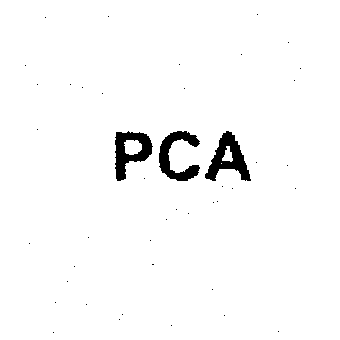

In [6]:
x = mpimg.imread('../../a.png')
x[x<=.1] = -1
x[x>.1]=1
x = x[:, :524]
x = x[:, :, 0]

metropolis_ising(T=1,runtime=100,grid=x)

In [1]:
# from https://rosettacode.org/wiki/Abelian_sandpile_model#Python
# this file just simulates the sandpile, no analysis
class AbelianSandpile:
    def __init__(self, size, ic, snn = False):
        """
        Initialize initial grid size (width) and initial starting amount ic

        If snn is True, simulates sandpile as a spiking neural network, only saving a binary representation
        of the grid (where threshold is a spike)

        if ic is a list, initializes with random initial conditions with parameters:
        [%percent of grid initiated, number of grains at each burst, variability in drop size: if 1 all are same size]
        """
        self.size = size
        self.grid = np.zeros((size,size), int)

        if type(ic) in [list, tuple]: #still have to implement var in drop size
            pcnt_on = ic[0]
            num_rand = int(size*size*pcnt_on)
            self.rand_loc = self.gen_rand_coords(num_rand)
            for coord in self.rand_loc:
                x, y = coord[0], coord[1]
                self.grid[x][y] = ic[1]

        else:
            i1, i2 = int(size/2 - 1), int(size/2)
            self.grid[i1:i2, i1:i2] = ic #so it starts somewhere near the center

        self.raster = []
        self.snn = snn

    def gen_rand_coords(self, num_rand):
        """helper function to generate random coordinates"""
        rand_loc = []
        def recursive_gen():
            for i in np.arange(num_rand):
                rand_coord = list(np.random.randint(0,self.size,2))
                if len(rand_loc) == num_rand:
                    break
                if rand_coord not in rand_loc:
                    rand_loc.append(rand_coord)
                else:
                    recursive_gen()
        recursive_gen()
        return rand_loc

    def iterate(self, grid, save_evol):
        changed = False
        for i, row in enumerate(grid):
            for j, height in enumerate(row):
                if height > 3:
                    grid[i,j] -= 4

                    if i > 0:
                        grid[i - 1, j] += 1
                    if i < len(grid)-1:
                        grid[i + 1, j] += 1
                    if j > 0:
                        grid[i, j - 1] += 1
                    if j < len(grid)-1:
                        grid[i, j + 1] += 1

                    changed = True

        if self.snn: #maybe this should be in simulate
            copy = grid.copy()
            copy[copy < 4] = 0
            copy[copy >= 4] = 1

            self.raster.append(copy.flatten())

        elif save_evol and not self.snn:
            copy = grid.copy()
            self.raster.append(copy)
        return grid, changed

    def simulate(self, save_evol):
        grid = self.grid.copy()
        t = 0
        while True:
            grid, changed = self.iterate(grid, save_evol)
            if not changed:
                return grid

    def run(self, save_evol = False):
        """save_evol saves each time point.  if snn, does this automatically"""
        if self.snn:
            save_evol = True
        final_grid = self.simulate(save_evol)
        plt.figure(figsize=(12,8))
        plt.subplot(1,2,1)
        plt.gray()
        plt.imshow(self.grid)
        plt.subplot(1,2,2)
        plt.gray()
        plt.imshow(final_grid)
        plt.show()

        if save_evol or self.snn:
            return self.raster
        else:
            return final_grid

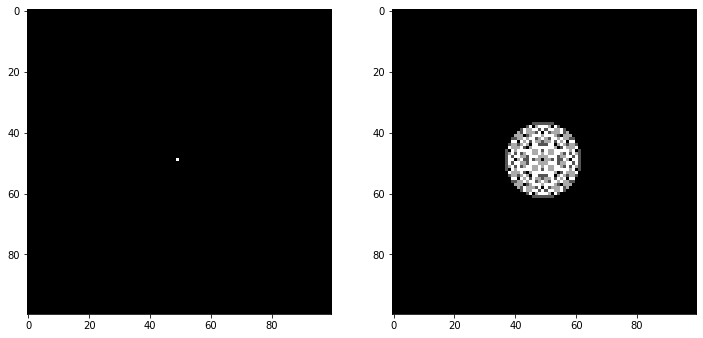

In [6]:
sandy = AbelianSandpile(100, 1000)
x = sandy.run()

# Game of Life
<!-- language: python -->

```
[i-1][j-1]| [i-1][j]| [i-1][j+1]
[i] [j+1] | [i] [j] | [i] [j+1]
[i+1][j-1]| [i-1][j]| [i+1][j+1]
```

In [25]:
[[r,c] for r in (0,1,-1) for c in (0,1,-1)]

[[0, 0], [0, 1], [0, -1], [1, 0], [1, 1], [1, -1], [-1, 0], [-1, 1], [-1, -1]]

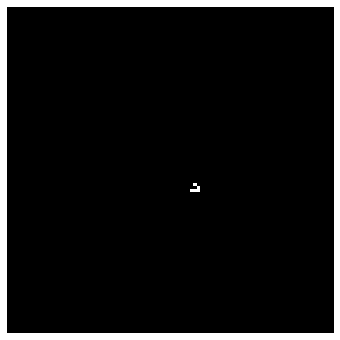

In [36]:
def run_life(size, runtime):
    grid = np.zeros((size,size), int)
    grid[int(size/2)][int(size/2)] = 1
    grid[int(size/2)][int(size/2) +1] =1
    grid[int(size/2)][int(size/2) + 2] = 1
    grid[int(size/2) - 1][int(size/2) +2] =1
    grid[int(size/2) -2][int(size/2) +1] =1
    grids = []
    for t in range(runtime):
        updates = []
        grids.append(grid)
        
        #plot
        plt.figure(figsize=(6,6)) 
        plt.imshow(grid,cmap='gray')
        plt.axis('off')
        clear_output(wait=True)
        plt.show()
        for i in range(1, size - 1):
            for j in range(1, size - 1):
                state = grid[i][j]
                #try:
                neighbors = [grid[i+r][j+c] for r in (0,1,-1) for c in (0,1,-1)][1:] #without the cell itself
                if state == 1:
                    if sum(neighbors) >= 4:
                        new_state = 0
                    elif sum(neighbors) <= 1:
                        new_state = 0
                    else: new_state = 1 # 2,3 case
                elif state == 0:
                    if sum(neighbors) == 3:
                        new_state = 1
                    else: new_state = 0
                if state != new_state:
                    updates.append((i,j,new_state))
        for u in updates:
            i,j, new = u[0],u[1],u[2]
            grid[i][j] = new
        
run_life(100,25)

# Misc stuff

I guess trying to implement a cool state machine

In [ ]:
class Grid(State):
    def __init__(self, t0, t):
#         self.grid = np.zeros((size, size))
#         for n_i, row in enumerate(t0):
#             for col in row:
#                 if t0
        self.grid = t0
        self.life_time = t
        
    def run(self):
        run = True
        while run:
            
class State(object):
    def __init__(self, state, t0, t):
        Grid.__init__(self, t0, t)
        self.transition_dict = {"A":"B",
                               "B":"A"}
    def transition(self,state,curr):
        return curr_shape(self.transition_dict(curr))
    
    def curr_shape(self, s):
        shape_dict = {"A": [['*']], "B":[["*", ' ',"*"]]}
        return shape_dict[s]

In [178]:
primes

[29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101]